# Using EDRep

We focus on the main function of this package, ```CreateEmbedding```, which is the implementation of Algorithm 1 of our [**paper**](https://openreview.net/pdf?id=9M4NKMZOPu). The function is called in the following way

```python
res = CreateEmbedding(Pv)
```

Here ```Pv``` is a list of scipy sparse arrays. The `EDRep` algorithm generates an embedding from a probability matrix `P`. In this case, we should write `Pv = [P]`. The sparsity of `P` is crucial to keep high efficiency. Suppose that `P` can be written as the product of sparse matrices ($P = P_3P_2P_1$). Even if all the matrices in the product are sparse, `P` can be dense. In our implementation, we explicitly consider this factorization as a possible input and would have `Pv = [P1, P2, P3]`. This allows a much faster implementation. We now show this on some synthetic data.

> **Remark**: note that the matrices are ordered in the opposite direction.

In [1]:
# load the needed package
import numpy as np
from scipy.sparse import csr_matrix
from time import time
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import diags

from EDRep import CreateEmbedding

## The main input and output of the function

In [2]:
# generate a sequence Pv to be embedded. Each matrix should be a probability matrix
n = 2500
At = [np.random.binomial(10, 5/n, (n, n)) for _ in range(5)]
Pv = []

for A in At:
    v = np.maximum(1, A@np.ones(n))
    Pv.append(csr_matrix(np.diag(v**(-1))@A))

Running the optimization for k = 1
Execution time aggregated version: 20.11892533302307

Running the optimization for k = 1
Execution time efficient implementation: 2.27961802482605


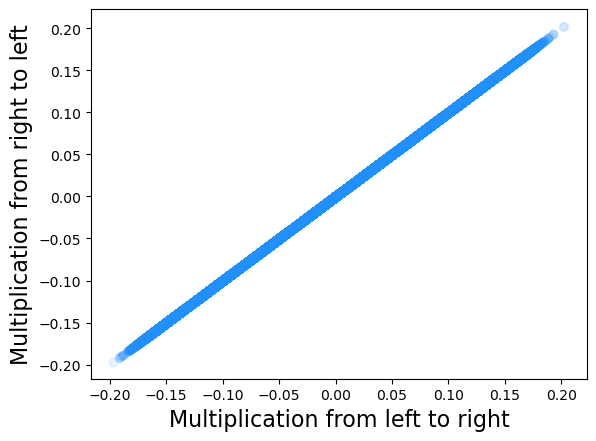

In [4]:
# we compare the execution time of the two versions of the algorithm 
t0 = time()
np.random.seed(123)
P = np.prod(Pv[::-1])
res_agg = CreateEmbedding([P])
print(f'Execution time aggregated version: {time() - t0}\n')

t0 = time()
np.random.seed(123)
res = CreateEmbedding(Pv)
print(f'Execution time efficient implementation: {time() - t0}')

## PLOT
plt.scatter(res.X.flatten(), res_agg.X.flatten(), alpha = 0.1, color = 'dodgerblue')
plt.xlabel('Multiplication from left to right', fontsize = 16)
plt.ylabel('Multiplication from right to left', fontsize = 16)
plt.show();

To access the embedding we simply need to type ```res.X```. Let us check that the embeddings obtained by the two implementations are actually the same.

>**Remark**
>
>We simply created random entries to test the algorithm. This implies that the matrix $P$ can be non-symmetric and weighted. The only >requirement we ask is that it is non-negative and the its rows sum up to $1$.

## Other inputs

All other inputs of this function are optional. We describe them here for convenience.

* ```dim```: this is the size of the embedding dimension and it should be an integer. 
* ```n_epochs```: this is the number of gradient descent steps from the initial condition and it should be an integer.
* ```eta```: this is the initial value of the learning parameter
* ```verbose```: if `True` it prints the progress bar and otherwise it doesn't.
* ```k```: this sets the order of the multivariate Gaussian approximation presented in the paper. If this parameter is not specified it is set to $1$ by deault. If it is set to $k > 1$, the algorithm is run for $k = 1$, then a label partition is inferred on $k > 1$ clusters and it is rerun for the updated parameters.

Let us now focus on other three optional inputs that are less straightforward.

### ```sum_partials```

This variable is a Boolean. If it is set to `True` it assumes that $P \propto P_1 + P_2P_1 + P_3P_2P_1$. We thought of this to easily model random walks of varying length on graphs. Let us check!

Running the optimization for k = 1
Execution time aggregated version: 19.37092089653015
Running the optimization for k = 1
Execution time efficient implmentation: 2.8942296504974365


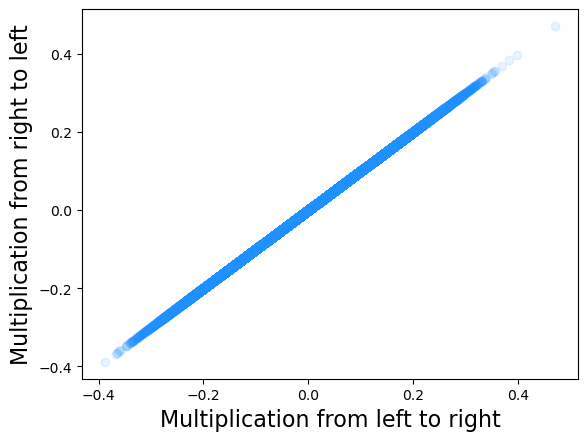

In [5]:
P = [Pv[0]]
for t in range(1, len(Pv)):
    P.append(Pv[t]@P[-1])
P = np.sum(P)/len(Pv)

t0 = time()
np.random.seed(123)
res_agg = CreateEmbedding([P], sum_partials = False)
print(f'Execution time aggregated version: {time() - t0}')

t0 = time()
np.random.seed(123)
res = CreateEmbedding(Pv, sum_partials = True)
print(f'Execution time efficient implmentation: {time() - t0}')

## PLOT
plt.scatter(res.X.flatten(), res_agg.X.flatten(), alpha = 0.1, color = 'dodgerblue')
plt.xlabel('Multiplication from left to right', fontsize = 16)
plt.ylabel('Multiplication from right to left', fontsize = 16)
plt.show();

### `sym`

This is a boolean variable that allows one to use the asymmetric version of the algorithm. If `sym = False`, instead of optimizing over ${\rm SoftMax}(XX^T)$, two embedding matrices are used, and the loss function features the term ${\rm SoftMax}(XY^T)$, with $X \in \mathbb{R}^{n \times d}$ and $Y\in\mathbb{R}^{m \times d}$ with $m$ potentially different from $n$. In other words, this allows the user to embed a rectangular matrix $P\in\mathbb{R}^{n \times m}$ in which the rows and the columns span different spaces. 

We provide a simple use case from matrix completion systems. We consider the [*RetailRocket* dataset](https://www.kaggle.com/datasets/retailrocket/ecommerce-dataset) (Zykov et al., 2022) which contains a sequence of events collected from a commerce website. Each event is associated with a time stamp, a user id, an item id, and an event type that can be “view”, “add to cart”, or “transaction”. We create a matrix $A_{ia}$ by letting its entry be equal to $1$ if user $i$ interacted at any time with item $a$, and we let $P$ be the row-normalized version of $A$. We then suppose we only observe a fraction of the events and use embedding vectors to guess whether a non-observed edge exists or not. We train the embedding with the non-symmetric version of the `EDRep` algorithm and then we create two samples of edges: one from the test set, the other composed of random node pairs. We then compute the F1 score, assuming that if $x_i^Ty_a > 0$, then the edge exists.

In [6]:
# load the dataset
df = pd.read_csv('data/events.csv')

# preprocess the data

# create an edge list between visitors and items
df = df.groupby(['visitorid', 'itemid']).sum().reset_index()[['visitorid', 'itemid']]

# map visitor ids to integers
all_visitor_id = df.visitorid.unique()
n = len(all_visitor_id)
visitor_mapper = dict(zip(all_visitor_id, np.arange(n)))

# map item ids to integers
all_item_id = df.itemid.unique()
m = len(all_item_id)
item_mapper = dict(zip(all_item_id, np.arange(m)))

df.visitorid = df.visitorid.map(lambda x: visitor_mapper[x])
df.itemid = df.itemid.map(lambda x: item_mapper[x])

print('Pre-processed data:\n')
df

Pre-processed data:



,visitorid,itemid
0,0,0
1,0,1
2,0,2
3,1,3
4,2,4
...,...,...
2145174,1407575,92255
2145175,1407576,36504
2145176,1407577,61448
2145177,1407578,22299


In [7]:
# probability of observing an edge
p = 0.7
nrows = len(df)
dim = 8

# create train and test sets
train_bool = np.random.binomial(1, p, nrows) == 1
df_train = df[train_bool]
df_test = df[~train_bool]

# obtain the probability matrix from the train set
A = csr_matrix((np.ones(len(df_train)), (df_train.visitorid, df_train.itemid)), shape = (n,m))
d = np.maximum(1, A@np.ones(m))
D_1 = diags(d**(-1))
P = D_1@A

# compute the embeddings
res = CreateEmbedding([P], dim = dim, sym = False)

Running the optimization for k = 1


In [8]:
tp = np.mean(np.sum(res.X[df_test.visitorid] * res.Y[df_test.itemid], axis = 1) > 0) 
fp = 1 - tp

idx1, idx2 = np.random.choice(np.arange(n), len(df_test)), np.random.choice(np.arange(m), len(df_test)) 
tn = np.mean(np.sum(res.X[idx1] * res.Y[idx2], axis = 1) < 0)
fn = 1 - tn

F1 = 2*tp/(2*tp + fp + fn)
print(f'F1 score: {F1}')

F1 score: 0.7113445864413995
